# Titration Experiment

In [1]:
#############################
#   Experiment parameters   #
#############################
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
EXPERIMENT = 'primary_immune'
TITRATING_CELLTYPE = 'Blueprint-B'
TITRATING_CELLTYPE_ATLAS = 'immune_b' # cell type name in atlas different
BACKGROUND = 'wholeblood' # background: uniform / wholeblood 
N_REPLICATES = 2 # number of replicates for each mixture
SEED = 888 # need to change for different experiment
TOTAL_READS_TO_SAMPLE = 1000000

# make sure the orders of the two list match
CELLTYPES = ['Blueprint-CD4', 'Blueprint-CD8', 'Blueprint-B', 'Blueprint-NK', 'Blueprint-Mono', 'Blueprint-Neutro']
ABRIDGED_NAMES = ['CD4', 'CD8', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

TITRATION_LIST = [0.2, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
                   0.008, 0.006, 0.004, 0.002, 0.001, 0]
# TITRATION_LIST=[0.2, 0.15]

# proportion of cells in real whole blood (sum to 1)
WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
                         'Blueprint-Mono':0.09,
                         'Blueprint-Neutro':0.57,
                         'Blueprint-CD4':0.16,
                         'Blueprint-CD8':0.07,
                         'Blueprint-NK':0.05}
    

In [2]:
# Parameters
ROOT_DIR = "/analysis/gh-msun/"
PROJECT_SLUG = "2023_06_26_SRT_deconvolution_MS"
EXPERIMENT = "primary_immune_loyfer"
TITRATING_CELLTYPE = "Blood-Mono+Macro"
TITRATING_CELLTYPE_ATLAS = "immune_dend_plus_macro_plus_mono"
BACKGROUND = "wholeblood"
N_REPLICATES = 20
SEED = 466724
TOTAL_READS_TO_SAMPLE = 1000000
CELLTYPES = ["Blood-B", "Blood-CD4", "Blood-CD8", "Blood-Mono+Macro", "Blood-NK", "Blood-Granul"]
ABRIDGED_NAMES = ["B", "CD4", "CD8", "MONO", "NK", "GRANUL"]
TITRATION_LIST = [0.2, 0.15, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.006, 0.004, 0.002, 0.001, 0]
WHOLE_BLOOD_ABUNDANCE = {"Blood-B": 0.06, "Blood-Mono+Macro": 0.09, "Blood-Granul": 0.57, "Blood-CD4": 0.16, "Blood-CD8": 0.07, "Blood-NK": 0.05}


In [3]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [4]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [6]:
#################################
#   Set titration proportions   #
#################################

# Reorder such that the titrating cell type comes first
CELLTYPES_unordered = CELLTYPES.copy()
CELLTYPES = hlpr.titration_reordering(list_of_cell_types=CELLTYPES, 
                                      titrating_cell_type=TITRATING_CELLTYPE)

# Reorder abridged name
ABRIDGED_NAMES = hlpr.reorder_abridged_name(unordered_celltypes=CELLTYPES_unordered,
                                            ordered_celltypes=CELLTYPES,
                                            unordered_abridged_names=ABRIDGED_NAMES)
    
# set titration proportions
if BACKGROUND == 'uniform':
    PROPORTIONS = hlpr.generate_uniform_background_proportions(titration_list=TITRATION_LIST, 
                                                               cell_types=CELLTYPES)

if BACKGROUND == 'wholeblood':
    PROPORTIONS = hlpr.generate_custom_background_proportions(titration_list=TITRATION_LIST, 
                                                              custom_proportion=WHOLE_BLOOD_ABUNDANCE, 
                                                              list_of_celltypes=CELLTYPES, 
                                                              titrating_celltype=TITRATING_CELLTYPE)

PROPORTIONS[0]    

[0.2,
 0.052747252747252754,
 0.1406593406593407,
 0.061538461538461556,
 0.043956043956043966,
 0.5010989010989011]

## Create mixture

In [7]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [8]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                    #    n=len(TITRATION_LIST), 
                                       n=N_REPLICATES,
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=ABRIDGED_NAMES, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: Blood-Mono+Macro


----------> Loading cell type: Blood-B


----------> Loading cell type: Blood-CD4


----------> Loading cell type: Blood-CD8


----------> Loading cell type: Blood-NK


----------> Loading cell type: Blood-Granul


>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.2, 0.052747252747252754, 0.1406593406593407, 0.061538461538461556, 0.043956043956043966, 0.5010989010989011]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.15, 0.056043956043956046, 0.14945054945054945, 0.0653846153846154, 0.046703296703296704, 0.5324175824175824]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.1, 0.059340659340659345, 0.15824175824175826, 0.06923076923076925, 0.049450549450549455, 0.5637362637362637]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.08, 0.060659340659340664, 0.16175824175824177, 0.07076923076923079, 0.05054945054945056, 0.5762637362637363]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.06, 0.06197802197802198, 0.16527472527472528, 0.07230769230769232, 0.05164835164835165, 0.5887912087912087]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.04, 0.0632967032967033, 0.1687912087912088, 0.07384615384615387, 0.052747252747252754, 0.6013186813186813]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.02, 0.06461538461538462, 0.17230769230769233, 0.0753846153846154, 0.05384615384615385, 0.6138461538461538]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.01, 0.06527472527472528, 0.17406593406593407, 0.07615384615384617, 0.054395604395604404, 0.6201098901098901]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.008, 0.06540659340659341, 0.17441758241758243, 0.07630769230769233, 0.05450549450549451, 0.6213626373626373]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.006, 0.06553846153846155, 0.1747692307692308, 0.07646153846153848, 0.05461538461538462, 0.6226153846153846]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.004, 0.06567032967032967, 0.17512087912087915, 0.07661538461538463, 0.05472527472527473, 0.6238681318681318]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.002, 0.0658021978021978, 0.17547252747252748, 0.07676923076923078, 0.05483516483516484, 0.6251208791208791]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.001, 0.06586813186813187, 0.17564835164835166, 0.07684615384615387, 0.054890109890109895, 0.6257472527472527]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0, 0.06593406593406594, 0.17582417582417584, 0.07692307692307694, 0.05494505494505495, 0.6263736263736264]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


>>> Complete. <<< 

CPU times: user 1.5 s, sys: 387 ms, total: 1.89 s
Wall time: 25min 9s


## Compute score matrix

In [9]:
############################
#   Parameters and paths   # 
############################

FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_CELLTYPE_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR


In [10]:
cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')

In [11]:
# %%time
# ridxs = ~cpg_map['cpg_index_hg38'].isna()
# hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
# hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

In [12]:
region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)

# region_df['region_cpg_index_max'] -= 1
# region_df.sort_values('region_cpg_index_min', inplace=True)
# region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
# region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [13]:
# ridxs = ~region_df['region_cpg_index_min_hg38'].isna()
# ridxs &= ~region_df['region_cpg_index_max_hg38'].isna()
# region_df = region_df[ridxs].copy()
# region_df.shape[0], region_df['region_id'].nunique()

In [14]:
# cg_count_hg19 = region_df['region_cpg_index_max']-region_df['region_cpg_index_min'] + 1
# cg_count_hg38 = region_df['region_cpg_index_max_hg38']-region_df['region_cpg_index_min_hg38'] + 1
# ridxs = (cg_count_hg19==cg_count_hg38)
# ridxs &= (cg_count_hg19>=FILTER_CG_COUNT_REGION)
# region_df = region_df[ridxs].copy()
# region_df.shape[0], region_df['region_id'].nunique()

In [15]:
# region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min_hg38'].astype(int)
# region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max_hg38'].astype(int)

In [16]:
### Restrict to immune regions
#-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# BLUEPRINT immune regions
ATLAS_PATH = PROJECT_DIR + f'/output/reference/deconv_inhouse_v2.atlas.tsv.gz'
atlas = pd.read_csv(ATLAS_PATH, sep='\t')
subset_region_set = set(atlas.region_id)
#-----------------------------------------------------------------------------

# filter regions down to regions of interest
region_df = region_df[region_df['region_id'].isin(subset_region_set)]
region_df.head()

,region_chr,region_start,region_end,region_cpg_index_min,region_cpg_index_max,region_id
0,chr1,1114771,1114971,20117,20130,Immune_Broad_B-chr1:1114772-1114971
1,chr1,1157450,1157720,21684,21704,Immune_Broad_NK-chr1:1157451-1157720
2,chr1,1157879,1158277,21710,21727,Immune_Broad_NK-chr1:1157880-1158277
14,chr1,6341182,6341377,140667,140682,Immune_Broad_Eosi-chr1:6341183-6341377
19,chr1,9147788,9147871,188605,188609,Immune_Broad_Neutro-chr1:9147789-9147871


In [17]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string', 'region_id', 'region_cpg_index_min', 'region_cpg_index_max'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, schema=RETURN_SCHEMA, kmers=KMERS, rates_leq=RATES_LEQ, rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       region_df = region_df, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

>>> Start computing score matrices <<< 

--> E2MONO_E0527B_E1407CD4_E0615CD8_E044NK_E5011GRANUL
--------> Computing score matrix for mix0_seed967193


--------> Computing score matrix for mix1_seed969385


--------> Computing score matrix for mix2_seed446982


--------> Computing score matrix for mix3_seed887258


--------> Computing score matrix for mix4_seed779818


--------> Computing score matrix for mix5_seed409835


--------> Computing score matrix for mix6_seed765765


--------> Computing score matrix for mix7_seed117014


--------> Computing score matrix for mix8_seed926946


--------> Computing score matrix for mix9_seed578816


--------> Computing score matrix for mix10_seed184037


--------> Computing score matrix for mix11_seed725459


--------> Computing score matrix for mix12_seed35669


--------> Computing score matrix for mix13_seed889315


--------> Computing score matrix for mix14_seed199079


--------> Computing score matrix for mix15_seed830814


--------> Computing score matrix for mix16_seed828963


--------> Computing score matrix for mix17_seed208288


--------> Computing score matrix for mix18_seed92395


--------> Computing score matrix for mix19_seed358043




--> E15MONO_E056B_E1495CD4_E0654CD8_E0467NK_E5324GRANUL
--------> Computing score matrix for mix0_seed225862


--------> Computing score matrix for mix1_seed708147


--------> Computing score matrix for mix2_seed865047


--------> Computing score matrix for mix3_seed57816


--------> Computing score matrix for mix4_seed469857


--------> Computing score matrix for mix5_seed540482


--------> Computing score matrix for mix6_seed628177


--------> Computing score matrix for mix7_seed118846


--------> Computing score matrix for mix8_seed532864


--------> Computing score matrix for mix9_seed242297


--------> Computing score matrix for mix10_seed693262


--------> Computing score matrix for mix11_seed953912


--------> Computing score matrix for mix12_seed566096


--------> Computing score matrix for mix13_seed333027


--------> Computing score matrix for mix14_seed59


--------> Computing score matrix for mix15_seed501283


--------> Computing score matrix for mix16_seed441252


--------> Computing score matrix for mix17_seed430761


--------> Computing score matrix for mix18_seed628167


--------> Computing score matrix for mix19_seed146784




--> E1MONO_E0593B_E1582CD4_E0692CD8_E0495NK_E5637GRANUL
--------> Computing score matrix for mix0_seed407145


--------> Computing score matrix for mix1_seed374842


--------> Computing score matrix for mix2_seed231964


--------> Computing score matrix for mix3_seed595160


--------> Computing score matrix for mix4_seed880582


--------> Computing score matrix for mix5_seed577197


--------> Computing score matrix for mix6_seed968699


--------> Computing score matrix for mix7_seed821675


--------> Computing score matrix for mix8_seed315149


--------> Computing score matrix for mix9_seed63912


--------> Computing score matrix for mix10_seed688994


--------> Computing score matrix for mix11_seed596454


--------> Computing score matrix for mix12_seed998351


--------> Computing score matrix for mix13_seed738813


--------> Computing score matrix for mix14_seed288327


--------> Computing score matrix for mix15_seed987090


--------> Computing score matrix for mix16_seed106740


--------> Computing score matrix for mix17_seed343900


--------> Computing score matrix for mix18_seed503874


--------> Computing score matrix for mix19_seed387061




--> E08MONO_E0607B_E1618CD4_E0708CD8_E0505NK_E5763GRANUL
--------> Computing score matrix for mix0_seed328917


--------> Computing score matrix for mix1_seed134326


--------> Computing score matrix for mix2_seed608580


--------> Computing score matrix for mix3_seed572425


--------> Computing score matrix for mix4_seed940331


--------> Computing score matrix for mix5_seed996608


--------> Computing score matrix for mix6_seed611804


--------> Computing score matrix for mix7_seed756378


--------> Computing score matrix for mix8_seed548404


--------> Computing score matrix for mix9_seed23993


--------> Computing score matrix for mix10_seed830606


--------> Computing score matrix for mix11_seed61393


--------> Computing score matrix for mix12_seed209463


--------> Computing score matrix for mix13_seed843019


--------> Computing score matrix for mix14_seed704228


--------> Computing score matrix for mix15_seed122584


--------> Computing score matrix for mix16_seed253713


--------> Computing score matrix for mix17_seed454794


--------> Computing score matrix for mix18_seed665185


--------> Computing score matrix for mix19_seed808212




--> E06MONO_E062B_E1653CD4_E0723CD8_E0516NK_E5888GRANUL
--------> Computing score matrix for mix0_seed982459


--------> Computing score matrix for mix1_seed791117


--------> Computing score matrix for mix2_seed151887


--------> Computing score matrix for mix3_seed930298


--------> Computing score matrix for mix4_seed143383


--------> Computing score matrix for mix5_seed533066


--------> Computing score matrix for mix6_seed561035


--------> Computing score matrix for mix7_seed579853


--------> Computing score matrix for mix8_seed677862


--------> Computing score matrix for mix9_seed722633


--------> Computing score matrix for mix10_seed571774


--------> Computing score matrix for mix11_seed182448


--------> Computing score matrix for mix12_seed213766


--------> Computing score matrix for mix13_seed986422


--------> Computing score matrix for mix14_seed485747


--------> Computing score matrix for mix15_seed557432


--------> Computing score matrix for mix16_seed901266


--------> Computing score matrix for mix17_seed601400


--------> Computing score matrix for mix18_seed438360


--------> Computing score matrix for mix19_seed750452




--> E04MONO_E0633B_E1688CD4_E0738CD8_E0527NK_E6013GRANUL
--------> Computing score matrix for mix0_seed545178


--------> Computing score matrix for mix1_seed746698


--------> Computing score matrix for mix2_seed756021


--------> Computing score matrix for mix3_seed159897


--------> Computing score matrix for mix4_seed370196


--------> Computing score matrix for mix5_seed807216


--------> Computing score matrix for mix6_seed291728


--------> Computing score matrix for mix7_seed215184


--------> Computing score matrix for mix8_seed51297


--------> Computing score matrix for mix9_seed735378


--------> Computing score matrix for mix10_seed33744


--------> Computing score matrix for mix11_seed510523


--------> Computing score matrix for mix12_seed339256


--------> Computing score matrix for mix13_seed961686


--------> Computing score matrix for mix14_seed948767


--------> Computing score matrix for mix15_seed670788


--------> Computing score matrix for mix16_seed403015


--------> Computing score matrix for mix17_seed180378


--------> Computing score matrix for mix18_seed209787


--------> Computing score matrix for mix19_seed540203




--> E02MONO_E0646B_E1723CD4_E0754CD8_E0538NK_E6138GRANUL
--------> Computing score matrix for mix0_seed79955


--------> Computing score matrix for mix1_seed447642


--------> Computing score matrix for mix2_seed713195


--------> Computing score matrix for mix3_seed802340


--------> Computing score matrix for mix4_seed506971


--------> Computing score matrix for mix5_seed995789


--------> Computing score matrix for mix6_seed650094


--------> Computing score matrix for mix7_seed610763


--------> Computing score matrix for mix8_seed733558


--------> Computing score matrix for mix9_seed653189


--------> Computing score matrix for mix10_seed658741


--------> Computing score matrix for mix11_seed618019


--------> Computing score matrix for mix12_seed674509


--------> Computing score matrix for mix13_seed934571


--------> Computing score matrix for mix14_seed126403


--------> Computing score matrix for mix15_seed510856


--------> Computing score matrix for mix16_seed777377


--------> Computing score matrix for mix17_seed787543


--------> Computing score matrix for mix18_seed991526


--------> Computing score matrix for mix19_seed348994




--> E01MONO_E0653B_E1741CD4_E0762CD8_E0544NK_E6201GRANUL
--------> Computing score matrix for mix0_seed666217


--------> Computing score matrix for mix1_seed152103


--------> Computing score matrix for mix2_seed338956


--------> Computing score matrix for mix3_seed136919


--------> Computing score matrix for mix4_seed463023


--------> Computing score matrix for mix5_seed564562


--------> Computing score matrix for mix6_seed443284


--------> Computing score matrix for mix7_seed5033


--------> Computing score matrix for mix8_seed82189


--------> Computing score matrix for mix9_seed944797


--------> Computing score matrix for mix10_seed326698


--------> Computing score matrix for mix11_seed730730


--------> Computing score matrix for mix12_seed499410


--------> Computing score matrix for mix13_seed925689


--------> Computing score matrix for mix14_seed467280


--------> Computing score matrix for mix15_seed7026


--------> Computing score matrix for mix16_seed652799


--------> Computing score matrix for mix17_seed783381


--------> Computing score matrix for mix18_seed949567


--------> Computing score matrix for mix19_seed772347




--> E008MONO_E0654B_E1744CD4_E0763CD8_E0545NK_E6214GRANUL
--------> Computing score matrix for mix0_seed872093


--------> Computing score matrix for mix1_seed214100


--------> Computing score matrix for mix2_seed424293


--------> Computing score matrix for mix3_seed46509


--------> Computing score matrix for mix4_seed874658


--------> Computing score matrix for mix5_seed107861


--------> Computing score matrix for mix6_seed17969


--------> Computing score matrix for mix7_seed246088


--------> Computing score matrix for mix8_seed288629


--------> Computing score matrix for mix9_seed111453


--------> Computing score matrix for mix10_seed502254


--------> Computing score matrix for mix11_seed656493


--------> Computing score matrix for mix12_seed901889


--------> Computing score matrix for mix13_seed946040


--------> Computing score matrix for mix14_seed726406


--------> Computing score matrix for mix15_seed665681


--------> Computing score matrix for mix16_seed644034


--------> Computing score matrix for mix17_seed168647


--------> Computing score matrix for mix18_seed392474


--------> Computing score matrix for mix19_seed20916




--> E006MONO_E0655B_E1748CD4_E0765CD8_E0546NK_E6226GRANUL
--------> Computing score matrix for mix0_seed844259


--------> Computing score matrix for mix1_seed775462


--------> Computing score matrix for mix2_seed947499


--------> Computing score matrix for mix3_seed943337


--------> Computing score matrix for mix4_seed709305


--------> Computing score matrix for mix5_seed152369


--------> Computing score matrix for mix6_seed848912


--------> Computing score matrix for mix7_seed714416


--------> Computing score matrix for mix8_seed83466


--------> Computing score matrix for mix9_seed251720


--------> Computing score matrix for mix10_seed552282


--------> Computing score matrix for mix11_seed367790


--------> Computing score matrix for mix12_seed777127


--------> Computing score matrix for mix13_seed335653


--------> Computing score matrix for mix14_seed108025


--------> Computing score matrix for mix15_seed682335


--------> Computing score matrix for mix16_seed731214


--------> Computing score matrix for mix17_seed137348


--------> Computing score matrix for mix18_seed768054


--------> Computing score matrix for mix19_seed161527




--> E004MONO_E0657B_E1751CD4_E0766CD8_E0547NK_E6239GRANUL
--------> Computing score matrix for mix0_seed734540


--------> Computing score matrix for mix1_seed490276


--------> Computing score matrix for mix2_seed741452


--------> Computing score matrix for mix3_seed891755


--------> Computing score matrix for mix4_seed947087


--------> Computing score matrix for mix5_seed720752


--------> Computing score matrix for mix6_seed664736


--------> Computing score matrix for mix7_seed633420


--------> Computing score matrix for mix8_seed517100


--------> Computing score matrix for mix9_seed114356


--------> Computing score matrix for mix10_seed19031


--------> Computing score matrix for mix11_seed868981


--------> Computing score matrix for mix12_seed422691


--------> Computing score matrix for mix13_seed976622


--------> Computing score matrix for mix14_seed511716


--------> Computing score matrix for mix15_seed221307


--------> Computing score matrix for mix16_seed461595


--------> Computing score matrix for mix17_seed173530


--------> Computing score matrix for mix18_seed295009


--------> Computing score matrix for mix19_seed913892




--> E002MONO_E0658B_E1755CD4_E0768CD8_E0548NK_E6251GRANUL
--------> Computing score matrix for mix0_seed984004


--------> Computing score matrix for mix1_seed683556


--------> Computing score matrix for mix2_seed603736


--------> Computing score matrix for mix3_seed787058


--------> Computing score matrix for mix4_seed271232


--------> Computing score matrix for mix5_seed662922


--------> Computing score matrix for mix6_seed445477


--------> Computing score matrix for mix7_seed614361


--------> Computing score matrix for mix8_seed537423


--------> Computing score matrix for mix9_seed806299


--------> Computing score matrix for mix10_seed49385


--------> Computing score matrix for mix11_seed268719


--------> Computing score matrix for mix12_seed440368


--------> Computing score matrix for mix13_seed760851


--------> Computing score matrix for mix14_seed38761


--------> Computing score matrix for mix15_seed592651


--------> Computing score matrix for mix16_seed421245


--------> Computing score matrix for mix17_seed354812


--------> Computing score matrix for mix18_seed354678


--------> Computing score matrix for mix19_seed226281




--> E001MONO_E0659B_E1756CD4_E0768CD8_E0549NK_E6257GRANUL
--------> Computing score matrix for mix0_seed189194


--------> Computing score matrix for mix1_seed585395


--------> Computing score matrix for mix2_seed915436


--------> Computing score matrix for mix3_seed858685


--------> Computing score matrix for mix4_seed97341


--------> Computing score matrix for mix5_seed405913


--------> Computing score matrix for mix6_seed912226


--------> Computing score matrix for mix7_seed772059


--------> Computing score matrix for mix8_seed700840


--------> Computing score matrix for mix9_seed946948


--------> Computing score matrix for mix10_seed811454


--------> Computing score matrix for mix11_seed923561


--------> Computing score matrix for mix12_seed771020


--------> Computing score matrix for mix13_seed87182


--------> Computing score matrix for mix14_seed201738


--------> Computing score matrix for mix15_seed312823


--------> Computing score matrix for mix16_seed605772


--------> Computing score matrix for mix17_seed664745


--------> Computing score matrix for mix18_seed85142


--------> Computing score matrix for mix19_seed290974




--> EMONO_E0659B_E1758CD4_E0769CD8_E0549NK_E6264GRANUL
--------> Computing score matrix for mix0_seed444362


--------> Computing score matrix for mix1_seed144765


--------> Computing score matrix for mix2_seed372176


--------> Computing score matrix for mix3_seed496774


--------> Computing score matrix for mix4_seed568651


--------> Computing score matrix for mix5_seed999672


--------> Computing score matrix for mix6_seed390505


--------> Computing score matrix for mix7_seed710956


--------> Computing score matrix for mix8_seed87224


--------> Computing score matrix for mix9_seed118740


--------> Computing score matrix for mix10_seed3845


--------> Computing score matrix for mix11_seed189987


--------> Computing score matrix for mix12_seed757439


--------> Computing score matrix for mix13_seed876574


--------> Computing score matrix for mix14_seed407952


--------> Computing score matrix for mix15_seed156084


--------> Computing score matrix for mix16_seed877453


--------> Computing score matrix for mix17_seed994908


--------> Computing score matrix for mix18_seed371606


--------> Computing score matrix for mix19_seed608697




>>> Complete. <<< 

CPU times: user 16.5 s, sys: 985 ms, total: 17.5 s
Wall time: 43min 26s


## Deconvolution

In [18]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.tsplit.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.tsplit.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [19]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(285, 10)

In [20]:
ref_region_df['ref_celltype'][ref_region_df['ref_celltype'] == 'immune_cd4_t'] = 'immune_cd4'
ref_region_df['ref_celltype'][ref_region_df['ref_celltype'] == 'immune_cd8_t'] = 'immune_cd8'

In [21]:
%%time

deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

deconvolution_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)


CPU times: user 4.59 s, sys: 1.43 ms, total: 4.59 s
Wall time: 4.59 s


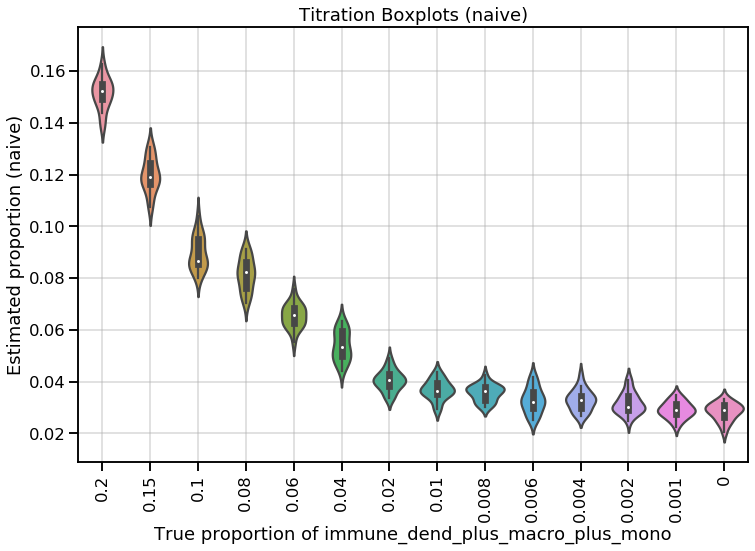

In [22]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

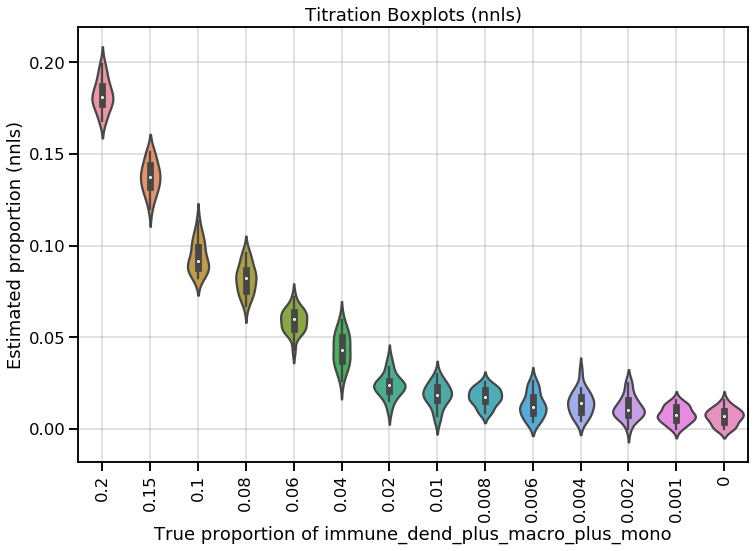

In [23]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )

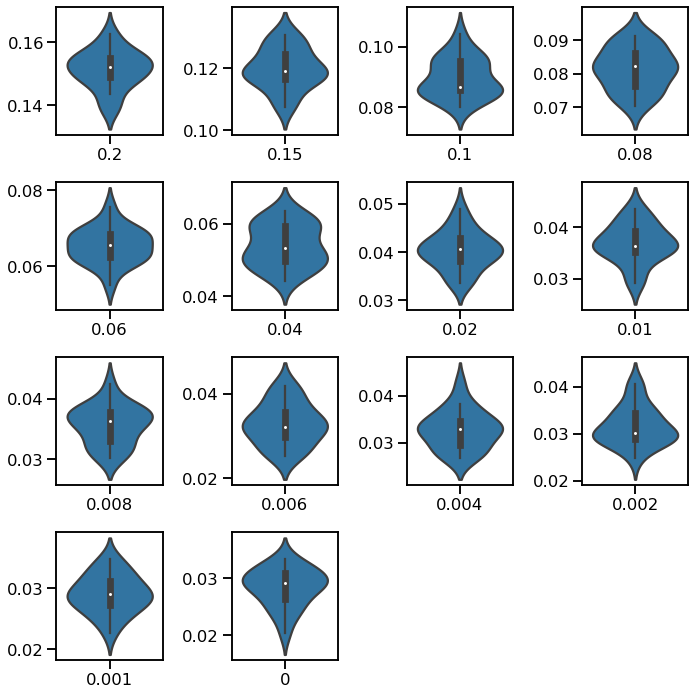

In [24]:
dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

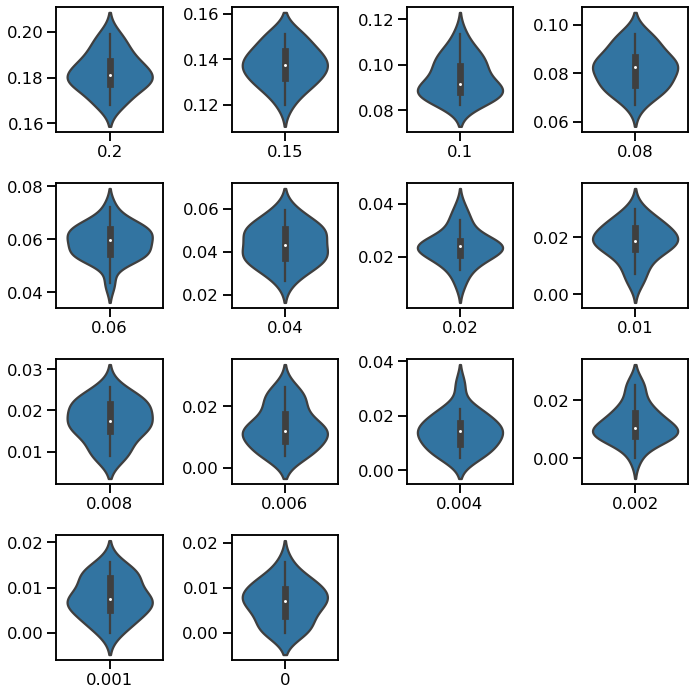

In [25]:
dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )

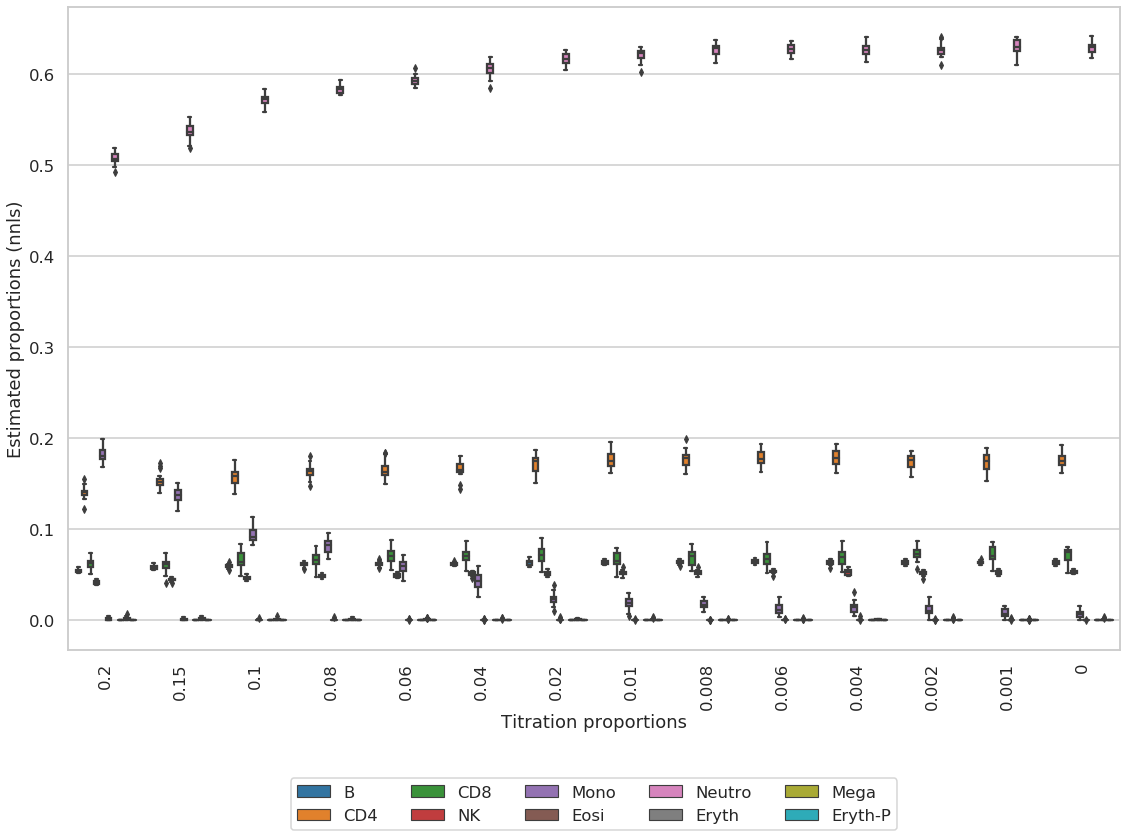

In [26]:
dcnv.background_estimates_boxplot(list_of_deconvolution_dfs = deconvolution_nnls, 
                             cell_types = ['B', 'CD4', 'CD8', 'NK', 'Mono', 'Eosi', 'Neutro', 'Eryth', 'Mega', 'Eryth-P'],
                            titration_proportions = TITRATION_LIST,
                            method = 'nnls')

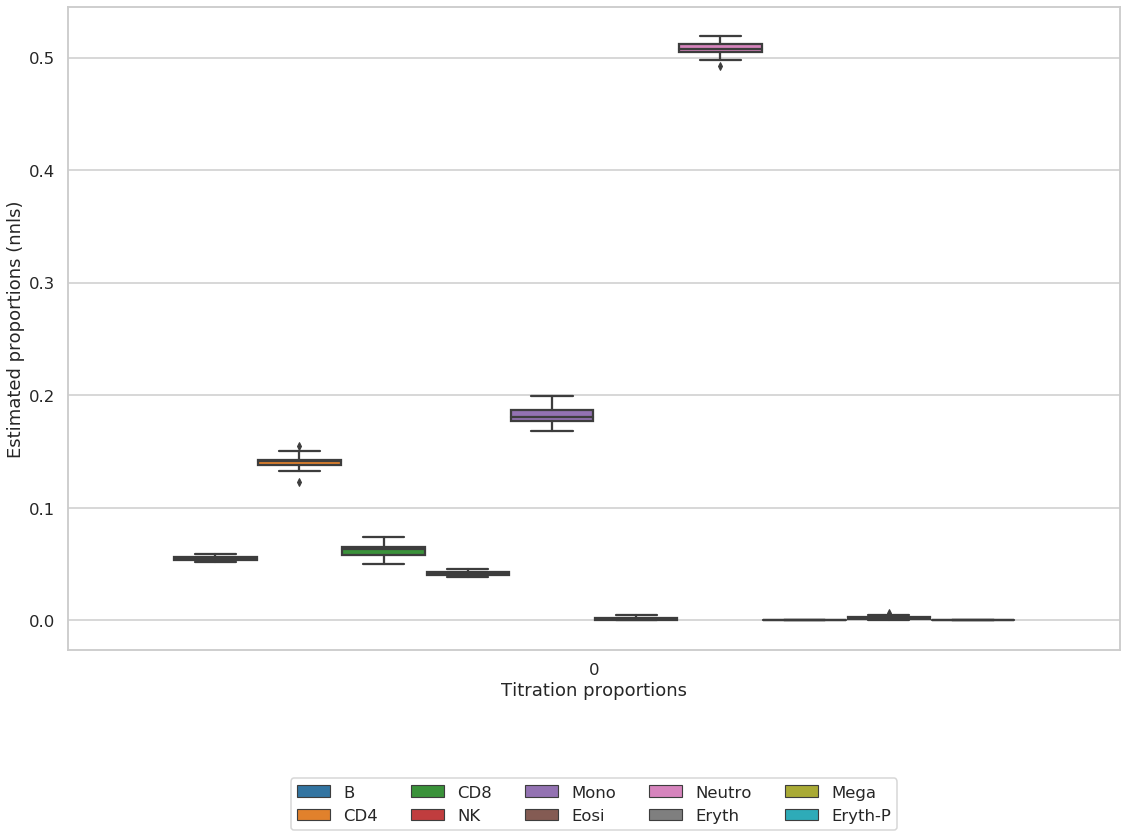

In [27]:
dcnv.background_estimates_boxplot_zoom(proportion=0.2,
                            list_of_deconvolution_dfs = deconvolution_nnls, 
                             cell_types = ['B', 'CD4', 'CD8', 'NK', 'Mono', 'Eosi', 'Neutro', 'Eryth', 'Mega', 'Eryth-P'],
                            titration_proportions = TITRATION_LIST,
                            method = 'nnls')